# Kostenabrechnung Maximus
## Import Tanken

In [1]:
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tanken_df = pd.read_csv('Maximus.csv',
                         skiprows=6,
                         skipfooter=144,
                         engine='python',
                         index_col=1,
                         usecols=[0, 2, 6],
                         encoding='utf-8',
                         header=0,
                         names=['Tachostand (km)', 'Datum', 'Kosten'])
tanken_df.index = pd.to_datetime(tanken_df.index)
tanken_df['Subtyp'] = 'Tanken'
tanken_df.head()

,Tachostand (km),Kosten,Subtyp
Datum,,,
2015-04-01 18:59:00,76157,60.18,Tanken
2015-04-04 19:24:00,77118,71.20,Tanken
2015-04-13 18:02:00,78048,71.83,Tanken
2015-04-24 17:42:00,78980,72.46,Tanken
2015-04-30 11:00:00,79833,63.05,Tanken


# Import Unterhalt

In [3]:
unterhalt_df = pd.read_csv('Maximus.csv',
                           skiprows=232,
                           skipfooter=37,
                           engine='python',
                           usecols=[0, 1, 2, 3, 7],
                           index_col=1,
                           encoding='utf-8')
unterhalt_df.index = pd.to_datetime(unterhalt_df.index)
unterhalt_df.head()

,Beschreibung,Tachostand (km),Kosten,Subtyp
Datum,,,,
2015-02-22 00:00:00,Kredit,76020.0,-17000.0,Finanzierung
2015-02-23 00:00:00,Kaufbetrag,76020.0,16180.0,Finanzierung
2015-03-02 00:00:00,Kreditrate 0,76020.0,350.0,Finanzierung
2015-03-09 14:00:00,Anzahlung,76020.0,500.0,Finanzierung
2015-03-30 07:19:00,Garantie,76020.0,499.0,Finanzierung


## Agglomerierter Unterhalt

In [4]:
joined_df = pd.concat([unterhalt_df, tanken_df])
joined_df = joined_df.sort_index()
joined_df['Weg'] = joined_df['Tachostand (km)'].diff()
joined_df.loc[joined_df.Weg.isna(), ['Weg']] = 0
joined_df.loc[(joined_df.Subtyp == 'Wartung') |
              (joined_df.Subtyp == 'Verschleißteile') |
              (joined_df.Subtyp == 'Reparatur') |
              (joined_df.Subtyp == 'Pflege') |
              (joined_df.Subtyp == 'Unfallschaden') |
              (joined_df.Subtyp == 'Tuning'), ['Subtyp']] = 'Wartung'
joined_df = joined_df.reset_index()
joined_df

,Datum,Beschreibung,Tachostand (km),Kosten,Subtyp,Weg
0,2015-02-22 00:00:00,Kredit,76020.0,-17000.00,Finanzierung,0.0
1,2015-02-23 00:00:00,Kaufbetrag,76020.0,16180.00,Finanzierung,0.0
2,2015-03-02 00:00:00,Kreditrate 0,76020.0,350.00,Finanzierung,0.0
3,2015-03-09 14:00:00,Anzahlung,76020.0,500.00,Finanzierung,0.0
4,2015-03-30 07:19:00,Garantie,76020.0,499.00,Finanzierung,0.0
...,...,...,...,...,...,...
321,2021-11-16 08:08:00,NaN,252260.0,83.17,Tanken,260.0
322,2021-12-04 17:44:00,NaN,253194.0,92.06,Tanken,934.0
323,2021-12-18 11:44:00,Diagnose Steuerkette,253640.0,53.79,Wartung,446.0
324,2021-12-21 00:00:00,Abmeldung,253640.0,7.80,Steuer,0.0


In [5]:
subtypes = joined_df.Subtyp.unique()
subtypes

array(['Finanzierung', 'Wartung', 'Tanken', 'Steuer', 'Versicherung'],
      dtype=object)

In [6]:
freq='1M'
aggregated_df = pd.DataFrame(index=pd.date_range('2015-01-01', '2022-01-31', freq=freq))

for ii in range(len(subtypes)):
    aggregated_df.loc[aggregated_df.index[0],
                      subtypes[ii]] = joined_df.query('Datum <= "%s" & Subtyp == "%s"' % (aggregated_df.index[0], 
                                                                                          subtypes[ii])).Kosten.sum()

for idx in aggregated_df.index[1:]:
    for ii in range(len(subtypes)):
        aggregated_df.loc[idx,
                          subtypes[ii]] = joined_df.query('Datum <= "%s" & Subtyp == "%s"' % (idx, 
                                                                                              subtypes[ii])).Kosten.sum()
        
        
aggregated_df.iloc[1:, :] = aggregated_df.diff().iloc[1:, :]
aggregated_df.loc[aggregated_df.Finanzierung < 0, ['Finanzierung']] = 0
aggregated_df.head()


,Finanzierung,Wartung,Tanken,Steuer,Versicherung
2015-01-31,0.0,0.00,0.00,0.0,0.00
2015-02-28,0.0,0.00,0.00,0.0,0.00
2015-03-31,1349.0,1048.59,0.00,0.0,0.00
2015-04-30,350.0,0.00,275.67,0.0,0.00
2015-05-31,350.0,0.00,442.04,230.0,253.42


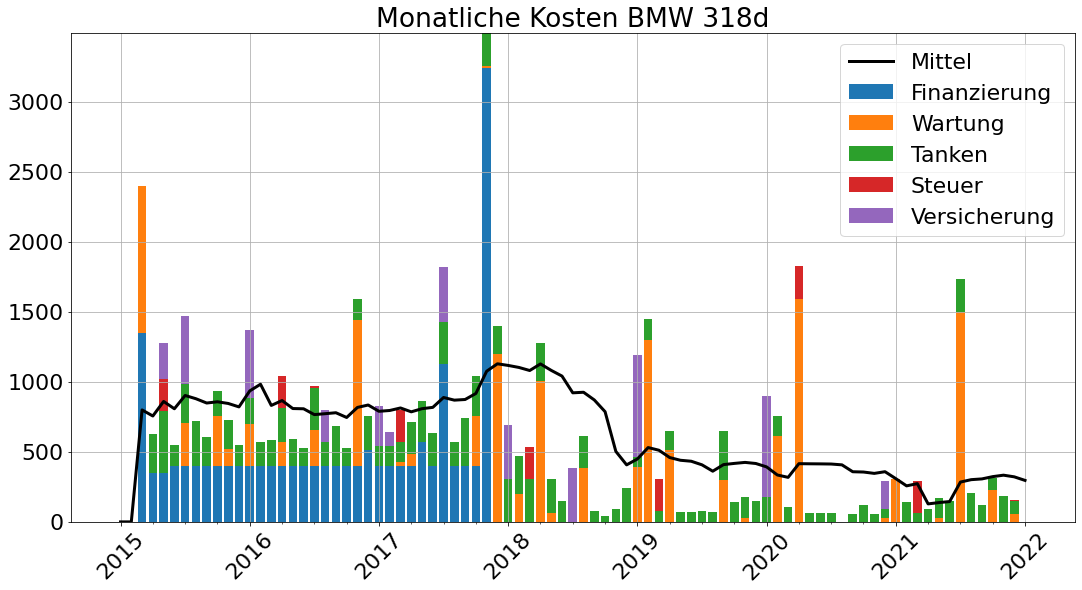

In [7]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

labels = aggregated_df.index.strftime('%Y')
idx = aggregated_df.reset_index().index
_, ax = plt.subplots(1, 1, figsize=(18,9))

bottom = np.zeros(aggregated_df.shape[0])

for column in aggregated_df.columns:
    ax.bar(idx, aggregated_df[column], 
           label=column,
           bottom=bottom,
           width=0.8, 
           align='center')
    bottom = bottom + aggregated_df[column]
ax.plot(idx, aggregated_df.sum(axis=1).rolling(12, min_periods=1).mean(),
       label='Mittel',
       linewidth=3,
       color='black')

ax.set_xticks(range(0,85,12))
ax.set_xticks(range(0,85,3), minor=True)
ax.set_xticklabels(list(labels[0:-1:12]) + list([labels[-1]]), rotation=45);
ax.set_title('Monatliche Kosten BMW 318d')
ax.grid(True);
ax.legend();

plt.savefig('images/kosten_maximus.png')

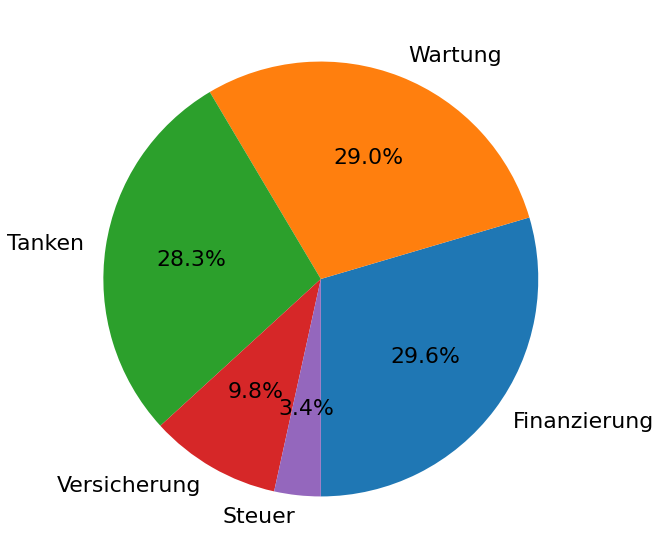

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
ax = joined_df.groupby('Subtyp').Kosten.sum().round(2).sort_values(ascending=False).plot(kind='pie',
                                                                     startangle=270,
                                                                     autopct='%1.1f%%',
                                                                     figsize=(15,10));
plt.ylabel('')
plt.savefig('images/kosten_verteilung.png')
plt.show()